## Access Satellite GHRSST L3S 1Day Daynighttime Single Sensor Southernocean data in Parquet
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l3s_1day_daynighttime_single_sensor_southernocean dataset available as a [Parquet](https://parquet.apache.org) dataset on S3

In [1]:
dataset_name = "satellite_ghrsst_l3s_1day_daynighttime_single_sensor_southernocean"

In [2]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [3]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 129 packages in 469ms


In [4]:
import requests
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [5]:
from parquet_queries import plot_gridded_variable

In [16]:
# remote zarr dataset
url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
ds

<xarray.Dataset> Size: 780GB
Dimensions:                    (time: 300, lat: 2500, lon: 10000)
Coordinates:
  * lat                        (lat) float32 10kB -27.51 -27.53 ... -77.49
  * lon                        (lon) float32 40kB 2.51 2.53 2.55 ... 202.5 202.5
  * time                       (time) datetime64[ns] 2kB 2024-01-01T11:10:00 ...
Data variables: (12/14)
    dt_analysis                (time, lat, lon) float64 60GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    l2p_flags                  (time, lat, lon) float32 30GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    quality_level              (time, lat, lon) float32 30GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    satellite_zenith_angle     (time, lat, lon) float64 60GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sea_surface_temperature    (time, lat, lon) float64 60GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sses_bias                  (time, lat, lon) float64 60GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    ...                         ...
    sst_count                  (time, lat, lon) float64 60GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_dtime                  (time, lat, lon) float64 60GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_mean                   (time, lat, lon) float64 60GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_standard_deviation     (time, lat, lon) float64 60GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    wind_speed                 (time, lat, lon) float64 60GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    wind_speed_dtime_from_sst  (time, lat, lon) float64 60GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.6
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Metadata_Link:              TBA
    acknowledgment:             Any use of these data requires the following ...
    cdm_data_type:              grid
    comment:                    HRPT AVHRR experimental L3 retrieval produced...
    ...                         ...
    summary:                    Skin SST retrievals produced from stitching t...
    time_coverage_end:          20230110T151752Z
    time_coverage_start:        20230109T232340Z
    title:                      IMOS L3S Day and Night gridded multiple-senso...
    uuid:                       226c6557-f9f7-4838-ac09-f861ecbf02d5
    westernmost_longitude:      2.509999990463257

## Timeseries at a point

In [ ]:
%%time
time_series_df = create_timeseries(ds, 'sea_surface_temperature', lat=-40, lon=130, start_time='2022-12-01', end_time='2023-12-31')

## Plot a gridded variable

Nearest date in dataset: <xarray.DataArray 'time' ()> Size: 8B
array('2024-01-26T11:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2024-01-26T11:10:00
Attributes:
    axis:           T
    comment:        A typical reference time for data
    long_name:      reference time of sst file
    standard_name:  time
Variable Long Name: sea surface foundation temperature
Error processing date 2024-01-26: No data available for 2024-01-26
Error processing date 2024-01-27: No data available for 2024-01-27
Error processing date 2024-01-28: No data available for 2024-01-28
Error processing date 2024-01-29: No data available for 2024-01-29
Error processing date 2024-01-30: No data available for 2024-01-30
Error processing date 2024-01-31: No data available for 2024-01-31
Error processing date 2024-02-01: No data available for 2024-02-01
Error processing date 2024-02-02: No data available for 2024-02-02
Error processing date 2024-02-03: No data available for 202

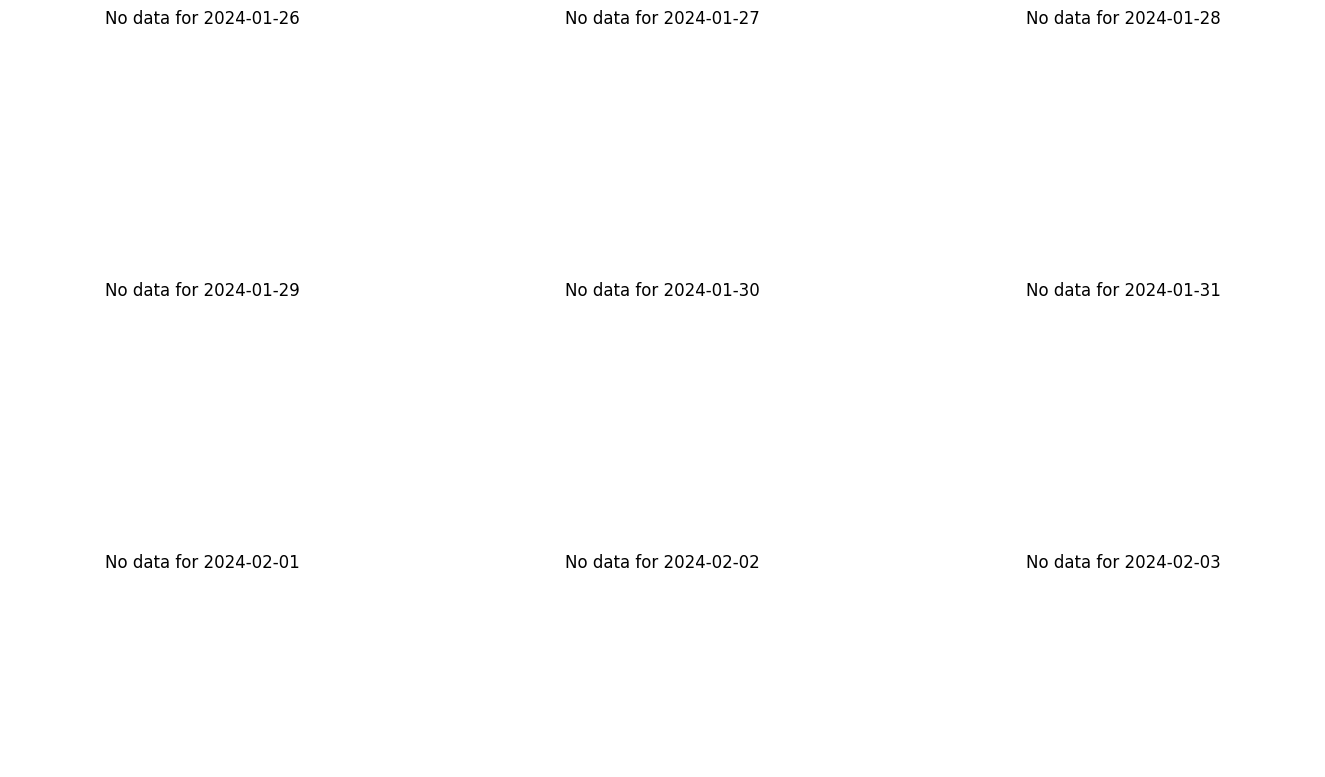

In [21]:
plot_gridded_variable(ds, start_date='2024-01-26', lon_slice=(4, 8), lat_slice=(-71, -69), var_name='sea_surface_temperature', n_days=9, coastline_resolution="10m")